# DOPP 2019W Exercise 3 - Group 32

### Contributors
- Eszter Katalin Bognar - 11931695
- Luis Kolb - 01622731
- Alexander Leitner - 01525882

### Objectives of the analysis
- What is the most accurate overview of flows of refugees between countries that can be obtained? 
- Are there typical characteristics of refugee origin and destination countries? 
- Are there typical characteristics of large flows of refugees? 
- Can countries that will produce large numbers of refugees be predicted? Can refugee flows be predicted?

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import logging
import hashlib

pd.options.mode.chained_assignment = None  # default='warn'

pd.options.mode.chained_assignment = None  # default='warn'
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

pd.options.mode.chained_assignment = None  # default='warn'

## Load datasets
We started our analysis by loading the necessary data files.

We selected 4 datasets to use:
- OECD International Migration Database data (https://stats.oecd.org/Index.aspx?DataSetCode=MIG)
- Gross Domestic Product per Capita data (https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)
- Human Development Index data (http://hdr.undp.org/en/data)
- World Governance Index data (https://datacatalog.worldbank.org/dataset/worldwide-governance-indicators)

Each dataset were loaded and formatted including:

- reshaping columns (changing rows to columns or columns to rows when necessary),
- getting rid of unwanted columns, 
- renaming columns, 
- setting proper data types,
- setting country-year multiindex to facilitate future data merge.

In [5]:
'''
Load & format OECD International Migration Database data
'''

def load_oecd_data():
    """ 
    Load oecd data file
    Reshape the dataset to have country, destination, year, asylum_seekers columns
    Set hierarchical index (country, year)
    
    Returns
    --------
    oecd: data frame containing oecd data
    """
    #load dataset
    oecd = pd.read_csv('data/oecd_data.csv',na_values=['..'])
    #reshape table
    oecd.set_index(['country','destination', 'year','variable'], inplace=True)
    oecd=oecd.unstack()
    oecd.columns = oecd.columns.droplevel(0)
    #drop unwanted columns
    oecd.reset_index(drop=False, inplace=True)
    #rename columns
    oecd = oecd[['country','destination','year','Inflows of asylum seekers by nationality']]
    oecd = oecd.rename(columns={'Inflows of asylum seekers by nationality': 'asylum_seekers'})
    #set index
    oecd=oecd.set_index(['country', 'year'])
    return oecd

oecd_df=load_oecd_data()
oecd_df.info()
oecd_df.head(20)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 131072 entries, (Afghanistan, 2000) to (Zimbabwe, 2017)
Data columns (total 2 columns):
destination       131072 non-null object
asylum_seekers    83187 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.4+ MB


variable         destination  asylum_seekers
country     year                            
Afghanistan 2000   Australia          1326.0
            2001   Australia          2161.0
            2002   Australia            53.0
            2003   Australia            54.0
            2004   Australia           116.0
            2005   Australia            32.0
            2006   Australia            21.0
            2007   Australia            20.0
            2008   Australia            52.0
            2009   Australia           940.0
            2010   Australia          1265.0
            2011   Australia          1720.0
            2012   Australia          3064.0
            2013   Australia           370.0
            2014   Australia           123.0
            2015   Australia           567.0
            2016   Australia          2563.0
            2017   Australia          1478.0
            2000     Austria          4205.0
            2001     Austria         12955.0

In [6]:
'''
Load & format Gross Domestic Product per Capita data
'''

def load_gdp_data():
    """ 
    Load gdp data file
    Reshape the dataset to have country, year, GDP columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    gdp: data frame containing gdp data
    """
    #load dataset
    gdp = pd.read_csv('data/GDPPC_data.csv',na_values=['..'])
    #drop unwanted columns
    gdp.drop(['Indicator Name','Indicator Code','Country Code' ], inplace=True, axis=1)
    #reshape dataframe
    gdp.set_index(['Country Name'], inplace=True)
    gdp=gdp.stack(dropna=False).to_frame()
    gdp.reset_index(drop=False, inplace=True)
    #rename columns
    gdp=gdp.rename(columns={'Country Name': 'country', 'level_1': 'year', 0: 'GDP'})
    #set datatype for year, GDP
    gdp['year']=gdp['year'].astype(int)
    gdp['GDP']=gdp['GDP'].astype(float)
    #only use data from 2000 onwards
    gdp = gdp[gdp.year >= 2000]
    #set index
    gdp=gdp.set_index(['country', 'year'])
    return gdp

gdp_df=load_gdp_data()
gdp_df.info()
gdp_df.tail(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5280 entries, (Aruba, 2000) to (Zimbabwe, 2019)
Data columns (total 1 columns):
GDP    4738 non-null float64
dtypes: float64(1)
memory usage: 59.1+ KB


GDP
country  year             
Zimbabwe 2010   948.331854
         2011  1093.654002
         2012  1304.969802
         2013  1430.000818
         2014  1434.899340
         2015  1445.071062
         2016  1464.583529
         2017  1602.403507
         2018  2146.996385
         2019          NaN

In [7]:
'''
Load & format Human Development Index data
'''

def load_hdi_data():
    """ 
    Load hdi data file
    Reshape the dataset to have country, year, HDI columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    hdi: data frame containing hdi data
    """
    #load dataset
    hdi = pd.read_csv('data/HDI.csv',na_values=['..'])
    #drop unwanted columns
    hdi.drop(['HDI Rank (2018)'], inplace=True, axis=1)
    #reshape dataframe
    hdi.set_index(['Country'], inplace=True)
    hdi=hdi.stack(dropna=False).to_frame()
    hdi.reset_index(drop=False, inplace=True)
    #rename columns
    hdi=hdi.rename(columns={'Country': 'country', 'level_1': 'year', 0: 'HDI'})
    #set datatype for year
    hdi['year']=hdi['year'].astype(int)
    hdi['HDI']=hdi['HDI'].astype(float)
    #only use data from 2000 onwards
    hdi = hdi[hdi.year >= 2000]
    #set index
    hdi=hdi.set_index(['country', 'year'])
    return hdi

hdi_df=load_hdi_data()
hdi_df.info()
hdi_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4028 entries, (Afghanistan, 2000) to (World, 2018)
Data columns (total 1 columns):
HDI    3788 non-null float64
dtypes: float64(1)
memory usage: 45.2+ KB


HDI
country     year       
Afghanistan 2000  0.345
            2001  0.347
            2002  0.378
            2003  0.387
            2004  0.400
            2005  0.410
            2006  0.419
            2007  0.431
            2008  0.436
            2009  0.447

In [8]:
'''
Load & format World Governance Index data

column values:
CC.EST: Control of Corruption: Estimate
GE.EST: Government Effectiveness: Estimate
PV.EST: Political Stability and Absence of Violence/Terrorism: Estimate
RL.EST: Rule of Law: Estimate
RQ.EST: Regulatory Quality: Estimate
VA.EST: Voice and Accountability: Estimate

'''


def load_wgi_data():
    """ 
    Load wgi data file
    Reshape the dataset to have country, year, WGI columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    hdi: data frame containing hdi data
    """
    #load dataset
    wgi = pd.read_csv('data/WGIData.csv',na_values=['..'])
    #drop unwanted rows
    wgi=wgi[wgi['Indicator Code'].str.contains('EST', regex= True, na=False)]
    #drop unwanted columns
    wgi.drop(['Country Code','Indicator Name'], inplace=True, axis=1)
    #reshape dataframe
    wgi.set_index(['Country Name','Indicator Code'], inplace=True)
    wgi=wgi.stack(dropna=False).to_frame()
    wgi.reset_index(drop=False, inplace=True)
    #rename columns
    wgi=wgi.rename(columns={'Country Name': 'country', 'level_2': 'year', 0: 'variable'})
    wgi.set_index(['country','year','Indicator Code'], inplace=True)
    wgi=wgi.unstack()
    wgi.columns = wgi.columns.droplevel(0)
    wgi.reset_index(drop=False, inplace=True)
    #set datatype for year 
    wgi['year']=wgi['year'].astype(int)
    #only use data from 2000 onwards
    wgi = wgi[wgi.year >= 2000]
    #set index
    wgi=wgi.set_index(['country', 'year'])
    return wgi
wgi_df=load_wgi_data()
wgi_df.info()
wgi_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3852 entries, (Afghanistan, 2000) to (Zimbabwe, 2018)
Data columns (total 6 columns):
CC.EST    3730 non-null float64
GE.EST    3720 non-null float64
PV.EST    3734 non-null float64
RL.EST    3769 non-null float64
RQ.EST    3719 non-null float64
VA.EST    3737 non-null float64
dtypes: float64(6)
memory usage: 193.8+ KB


Indicator Code      CC.EST    GE.EST    PV.EST    RL.EST    RQ.EST    VA.EST
country     year                                                            
Afghanistan 2000 -1.295380 -2.231651 -2.440187 -1.778437 -2.109626 -2.031417
            2002 -1.263366 -1.567973 -2.035389 -1.670823 -1.804449 -1.433421
            2003 -1.351042 -1.082488 -2.197809 -1.553829 -1.430002 -1.177571
            2004 -1.345281 -0.894051 -2.296179 -1.697143 -1.505863 -1.203034
            2005 -1.443609 -1.210829 -2.070934 -1.658668 -1.637369 -1.125430
            2006 -1.432890 -1.430343 -2.221302 -1.863189 -1.667902 -1.110294
            2007 -1.587331 -1.403352 -2.410581 -1.829666 -1.688257 -1.057654
            2008 -1.638287 -1.496089 -2.690477 -1.864380 -1.621583 -1.168902
            2009 -1.534796 -1.483899 -2.712689 -1.847092 -1.674311 -1.375497
            2010 -1.635723 -1.454683 -2.579152 -1.845436 -1.532861 -1.404468

## Country name inconsistency check 
Before data merge we have to check the datasets for inconsistencies. 
We would like to merge on the country-year multiindex.
Year is consistent in each data files however we have to search for different usage and typos in county names.
We selected oecd_df as base dataframe so we compare the country names in the oecd_df to the country names in the hdi_df, gdp_df, wgi_df datasets.

In [9]:
def country_check(countries, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    countries: list of countries (source or destination) in oecd_df
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    check: dataframe showing inconsistent country name usage
    """   
    #get country name list series
    hdi_c = hdi_df.index.unique(level=0).to_series()
    gdp_c = gdp_df.index.unique(level=0).to_series()
    wgi_c = wgi_df.index.unique(level=0).to_series()
    
    #create dataframe for the results
    check=pd.DataFrame(columns=['country','hdi','gdp','wgi'])
    #iterate through oecd_df source or destination country names and check presence of country name in other dfs
    for index,row in countries.iterrows():
        check=check.append({'country': row.country,
                            'hdi':row.isin(hdi_c).values[0],
                           'gdp':row.isin(gdp_c).values[0],
                           'wgi':row.isin(wgi_c).values[0]}, ignore_index=True)
        
    #add only problematic country rows to the result df
    check=check.loc[(check['hdi'] == False) | (check['gdp'] == False) | (check['wgi'] == False)]
    return check

oecd_s = pd.DataFrame(oecd_df.index.unique(level=0))
oecd_s_check = country_check(oecd_s,gdp_df, hdi_df, wgi_df)

oecd_d = pd.DataFrame(oecd_df['destination'].unique(),columns={'country'})
oecd_d_check = country_check(oecd_d,gdp_df, hdi_df, wgi_df)

display(oecd_d_check.head(50),oecd_s_check.head(50))
df = pd.concat([oecd_d_check,oecd_s_check])

,country,hdi,gdp,wgi
5,Czech Republic,False,True,True
18,Korea,False,False,False
27,Slovak Republic,False,True,True


,country,hdi,gdp,wgi
11,Bahamas,True,False,False
19,Bermuda,False,True,True
21,Bolivia,False,True,True
32,Cape Verde,False,False,False
37,Chinese Taipei,False,False,False
40,Congo,True,False,False
41,Cook Islands,False,False,True
46,Czech Republic,False,True,True
47,Côte d'Ivoire,True,False,False
48,Democratic People's Republic of Korea,False,False,False


For making the country names consistent, we first tried out the fuzzy search method of the fuzzywuzzy library. 
Due to errors, we finally decided to manually create a dictonary of country names to replace or delete them.

In [10]:
country_dict = {
    'Bahamas, The' :"Bahamas",
    'Bolivia (Plurinational State of)' :"Bolivia",
    'Cabo Verde' :"Cape Verde",
    'Congo, Rep.' :"Congo",
    'Czechia' :"Czech Republic",
    "Cote d'Ivoire" :"Côte d'Ivoire",
    'Congo, Dem. Rep.' :"Democratic Republic of the Congo",
    'Congo (Democratic Republic of the)':"Democratic Republic of the Congo",
    'Egypt, Arab Rep.' :"Egypt",
    'Gambia, The' :"Gambia",
    'Iran (Islamic Republic of)' :"Iran",
    'Iran, Islamic Rep.': "Iran",
    'Korea (Republic of)' :"Korea",
    'Korea, Rep.':"Korea",
    'Kyrgyz Republic' :"Kyrgyzstan",
    "Lao People's Democratic Republic" :"Laos",
    "Lao PDR":"Laos",
    'Micronesia (Federated States of)' :"Micronesia",
    'Micronesia, Fed. Sts.':'Micronesia',
    'Moldova (Republic of)' :"Moldova",
    'Russian Federation' :"Russia",
    'St. Kitts and Nevis' :"Saint Kitts and Nevis",
    'St. Lucia' :"Saint Lucia",
    'St. Vincent and the Grenadines' :"Saint Vincent and the Grenadines",
    'Slovakia' :"Slovak Republic",
    'Syrian Arab Republic' :"Syria",
    'Eswatini' :"Swaziland",
    "Eswatini (Kingdom of)": "Swaziland",
    'Tanzania (United Republic of)' :"Tanzania",
    'Venezuela (Bolivarian Republic of)' :"Venezuela",
    "Venezuela, RB":"Venezuela",
    'Vietnam' :"Viet Nam",
    'Yemen, Rep.' :"Yemen"  
}

country_del = [
    #former countries
    "Former Czechoslovakia",
    "Former USSR",
    "Former Yugoslavia",
    "Serbia and Montenegro",
    #China' territory
    "Macau",
    "Chinese Taipei",
    "Hong Kong, China",
    #USA's territory 
    "Guam",
    "Puerto Rico",
    #GB' territory
    "Bermuda",
    #New Zealand' territory
    "Cook Islands",
    "Tokelau",
    "Niue",
    #Palestina's territory
    "West Bank and Gaza Strip",
    #no proper data
    "Nauru",
    "San Marino",
    "Somalia",
    "Tuvalu",
    "Democratic People's Republic of Korea",
    "Monaco",
    "Not stated",
    "Unknown",
    "Total",
]

def country_correction(df):
    """ 
    Parameters
    --------
    df: dataframe with original country names

    Returns
    --------
    df_corrected: data frame with replaced country names
    """
    #rename country names  
    df_corrected=df.rename(index=country_dict, level=0)
    return df_corrected

#delete unwanted countries from the oecd_df base df
oecd_df=oecd_df.drop(country_del, level=0, errors='ignore')

#call country_correction() to rename country names
hdi_df=country_correction(hdi_df)
gdp_df=country_correction(gdp_df)
wgi_df=country_correction(wgi_df)


#check for inconsistencies again
countries = pd.DataFrame(oecd_df.index.unique(level=0))
oecd_check = country_check(countries,gdp_df, hdi_df, wgi_df)

if oecd_check.empty:
    print("No more inconsistent country names!")

No more inconsistent country names!


## Outlier detection
We checked the distribution of hdi, wgi and gdp data showing there are more poor than wealthy countries...We can not see any outliers. GDP is skewed towards zero, HDI is in the range of [0-1], wgi metrics are in the range of [-2-2].

In [ ]:
gdp_df['GDP'].hist(bins=50)

In [ ]:
hdi_df['HDI'].hist(bins=50)

In [ ]:
wgi_df[['CC.EST','GE.EST','PV.EST','RL.EST','VA.EST']].hist(bins=50)

## Handling missing values

### hdi, gdp and wgi datasets
After resolving the country name inconsistency and outlier check, we moved forward to examine outliers and missing values in the data files. We started with the analysis of the datasets to identify problematic areas, then implemented our solution to handle them. 
At this point we only focus on the hdi, gdp and wgi datasets since these datasets can be treated similarly. 
For the oecd dataset we will use other methods later. 

In [11]:
#investigating occurences of missing values in the datasets
display(hdi_df.isnull().sum())
display(gdp_df.isnull().sum())
display(wgi_df.isnull().sum())
#display a sample with missing values
display(hdi_df.iloc[hdi_df.index.get_level_values('country') == 'Eritrea'])

HDI    240
dtype: int64

GDP    542
dtype: int64

Indicator Code
CC.EST    122
GE.EST    132
PV.EST    118
RL.EST     83
RQ.EST    133
VA.EST    115
dtype: int64

HDI
country year       
Eritrea 2000    NaN
        2001    NaN
        2002    NaN
        2003    NaN
        2004    NaN
        2005  0.424
        2006  0.425
        2007  0.427
        2008  0.423
        2009  0.432
        2010  0.433
        2011  0.433
        2012  0.422
        2013  0.425
        2014  0.436
        2015  0.433
        2016  0.434
        2017  0.431
        2018  0.434

Since the hdi, gdp and wgi indicators can be treated equally and the values don't change rapidly from year to year we replace the missing data with the median of the data for the given country pairs. We selected this method because interpolation can't work properly where there are many missing values one after another. Where there weren't any data available for the given country pairs, we simply dropped the rows.

In [ ]:
#it is a bit slow, please be patient!
def handle_missingMetricValues(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    #if possible try to fill missing values with interpolation
    for i in incomplete_data.index.unique(level=0):
        columns=incomplete_data[incomplete_data.index.get_level_values('country')==i].columns
        for col in columns:
            #fill missing values with mean
            median=incomplete_data.loc[incomplete_data.index.get_level_values('country') == i][col].median()
            incomplete_data.loc[(incomplete_data.index.get_level_values('country') == i) & (incomplete_data[col].isnull()), col] = median            
    #drop rows where there isn't any data, sum can't be calculated
    complete_data=incomplete_data.dropna()
    return complete_data

hdi_complete=handle_missingMetricValues(hdi_df)
gdp_complete=handle_missingMetricValues(gdp_df)
wgi_complete=handle_missingMetricValues(wgi_df)

display(hdi_complete.isnull().sum())
display(gdp_complete.isnull().sum())
display(wgi_complete.isnull().sum())

display(hdi_complete.iloc[hdi_complete.index.get_level_values('country') == 'Eritrea'])

### Missing values in the oecd dataset
Examine the dataset and occurences of missing values

In [ ]:
display(oecd_df.info())
display(oecd_df.isnull().sum())
#examining the number of people flows for given source-destination country pairs
oecd=oecd_df.reset_index()
#change year to string to avoid aggregation by groupby
oecd['year']=oecd['year'].astype(str)
#set multiindex (country-destination)
oecd=oecd.set_index(['country','destination'])
#sum the number of asylum_seekers for each country-destination pairs
agg_df=oecd.groupby(oecd.index).sum(min_count=1)
display(agg_df)
#identify the country pairs where flows of people between the countries is zero
missing_pairs=agg_df.loc[(agg_df['asylum_seekers'] == 0) |(agg_df['asylum_seekers'].isnull())]
#list the missing country pairs 
display(missing_pairs)
display(oecd.iloc[(oecd.index.get_level_values('country') == 'Albania') & (oecd.index.get_level_values('destination') == 'Chile')])

There are a number of country pairs (e.g. Albania-Chile) where none of the years have inflows of asylum seekers between countries. Since we could not find any similar data source where there was appropiate data available for cold deck inputation. We assume that migration is not considerable between these countries and we decided to delete these rows from the final dataset. 

In [ ]:
#it is a bit slow, please be patient!
def delete_missingOECDValues(incomplete_data, missing_p):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    missing_p: list of country pairs with missing data
    
    Returns
    --------
    complete_data: data frame with deleted missing values
    """
    #set country-destination multiindex on the dataset
    incomplete_data=incomplete_data.reset_index()
    incomplete_data=incomplete_data.set_index(['country','destination'])
    #delete rows where none of the years have inflows of asylum seekers between the given country pairs
    for i in incomplete_data.index.unique():
        if np.any(i==missing_p.index):
            incomplete_data.drop(i,inplace=True)
    complete_data=incomplete_data
    return complete_data
oecd_deleted=delete_missingOECDValues(oecd_df, missing_pairs)

In [ ]:
#examine whether delete was successful or not
check=oecd_deleted.reset_index()
if check[(check['country']=='Albania') & (check['destination']=='Chile')].empty:
    display('Delete successful!')

For the remaining missing values, we calculated the mean of asylum_seekers for the given country pairs and filled the holes with this value.  

In [ ]:
def input_missingOECDValues(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame with inputted missing values, final dataframe that won't have missing values anymore
    """
    #set country-destination multiindex on the dataset
    incomplete_data=incomplete_data.reset_index()
    incomplete_data=incomplete_data.set_index(['country','destination'])
    #input missing values with median 
    for i in incomplete_data.index.unique():
        mean=incomplete_data.loc[(incomplete_data.index.get_level_values('country')==i[0]) & (incomplete_data.index.get_level_values('destination')==i[1])].mean()
        incomplete_data.loc[(incomplete_data.index.get_level_values('country') == i[0]) & (incomplete_data.index.get_level_values('destination')==i[1]) & (incomplete_data['asylum_seekers'].isnull()), 'asylum_seekers'] = mean.asylum_seekers
    complete_data=incomplete_data
    return complete_data
oecd_complete=input_missingOECDValues(oecd_deleted)
display(oecd_complete.isnull().sum())

In [ ]:
#set back country-year as index before data merge
oecd_complete=oecd_complete.reset_index()
oecd_complete=oecd_complete.set_index(['country','year'])

In [ ]:
def merge_dest(s_merged, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    s_merged: merged dataset with values for the source country
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    d_merged: merged data frame that contains complete migration and country data for the source and destination countries
    """
    s_merged = s_merged.rename(columns={'destination': 'country'})
    s_merged=s_merged.set_index(['year','country'])
    merge1=pd.merge(gdp_df, hdi_df, on=['year', 'country'])
    merge2=pd.merge(merge1, wgi_df, on=['year', 'country'])
    d_merged=pd.merge(merge2,s_merged,on=['year','country'])
    d_merged=d_merged.reset_index()
    d_merged = d_merged.rename(columns={'GDP': 'd_GDP',
                                             'HDI': 'd_HDI',
                                             'CC.EST': 'd_CC.EST',
                                             'GE.EST': 'd_GE.EST',
                                             'PV.EST': 'd_PV.EST',
                                             'RL.EST': 'd_RL.EST',
                                             'VA.EST': 'd_VA.EST',
                                             'RQ.EST': 'd_RQ.EST',
                                             'country': 'destination'})
    return d_merged


def merge_data(oecd_df, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    oecd_df: yearly data for foreign population inflow and asylum seeker inflow from source to destination country
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    merged_data: merged data frame that contains complete migration and country data
    
    """
    merge1=pd.merge(gdp_df, hdi_df, on=['year', 'country'])
    merge2=pd.merge(merge1, wgi_df, on=['year', 'country'])
    s_merged=pd.merge(merge2,oecd_df,on=['year','country'])
    s_merged=s_merged.reset_index()
    s_merged = s_merged.rename(columns={'GDP': 's_GDP',
                                             'HDI': 's_HDI',
                                             'CC.EST': 's_CC.EST',
                                             'GE.EST': 's_GE.EST',
                                             'PV.EST': 's_PV.EST',
                                             'RL.EST': 's_RL.EST',
                                             'VA.EST': 's_VA.EST',
                                             'RQ.EST': 's_RQ.EST',
                                             'country': 'source'})
    merged_data=merge_dest(s_merged,gdp_df, hdi_df, wgi_df)
    #set multiindex with year, source, destination
    merged_data=merged_data.set_index(['year','source'])
    
    return merged_data

data_merged = merge_data(oecd_complete, gdp_complete, hdi_complete, wgi_complete)
data_merged.to_csv("merged.csv")
data_merged.info()
data_merged

In [ ]:
display(data_merged.isnull().sum())

### Predictions
In this section we try to predict the refugee flow and see if this is possible. We use the liniar regression to do that. 

1) the merge data is allready preparet and are ready for further calculation 

In [1]:
countries = []   # creat a list to store the names of the countries who would like to predict the refugies flow
countries = ["Chad"]   # in this case the prediction of the country Chad
data_merged=data_merged.reset_index()   # to reshape the data set

NameError: name 'data_merged' is not defined

In [ ]:

# function to prepare the data set for the prediction
# input name of the country 
# output data target from the prediction and the datas from 2000 to 2016
def load_ref_data_predict(countries):
    # column names who will conentrate on

    # set which colums we want to use for the prediction
    columns = ["year","destination","source","d_VA.EST","d_GDP","d_HDI","d_CC.EST","d_GE.EST","d_PV.EST","d_RL.EST","s_GDP","s_HDI","s_GE.EST","s_PV.EST","s_RL.EST","s_RL.EST","s_VA.EST"] 
    ref_data_pred = data_merged[data_merged.year == 2017] # data set from only the year of 2017 
    ref_data = data_merged[data_merged.year != 2017] # data set from 2000 to 2016     
    ref_data = ref_data[ref_data["source"] == countries] # set the datas to the country the user like
    ref_data_pred = ref_data_pred[ref_data_pred["source"] == countries] # set the datas to the country the user like  
    # set the name from the destination and sorce to numbers this is important for the prediction
    ref_data['source'] = ref_data['source'].apply(lambda x:float(int(hashlib.sha1(x.encode('utf-8')).hexdigest(), 16)))
    ref_data['destination'] = ref_data['destination'].apply(lambda x:float(int(hashlib.sha1(x.encode('utf-8')).hexdigest(), 16)))   
    ref_data_pred['source'] = ref_data_pred['source'].apply(lambda x:float(int(hashlib.sha1(x.encode('utf-8')).hexdigest(), 16)))
    ref_data_pred['destination'] = ref_data_pred['destination'].apply(lambda x:float(int(hashlib.sha1(x.encode('utf-8')).hexdigest(), 16)))
    
    return ref_data_pred,ref_data





columns = ["year","destination","source","d_VA.EST","d_GDP","d_HDI","d_CC.EST","d_GE.EST","d_PV.EST","d_RL.EST","s_GDP","s_HDI","s_GE.EST","s_PV.EST","s_RL.EST","s_RL.EST","s_VA.EST"] 
# define a list which stores the results from the prediction
prediction_score = []
# for loop to run all countries that the user defines in the upper part
for i in countries:
    # call the upper definded function to prepare the data set for the prediction
    real,ref_pre_data = load_ref_data_predict(i)
    # define the training data set 
    descriptors = ref_pre_data[columns]
    # and the targt fo the  machine learning
    target = ref_pre_data[["asylum_seekers"]]



    np.random.seed(seed=12345) # get allways the same random generator
    msk = np.random.rand(len(descriptors)) <= 0.85 # mask to split the dataset into the training and test set
    # for 10 fold cross validation we would need to make more splits like 0.95, 0.85, 0.75, ...
    training_data = descriptors[msk]
    test_data = descriptors[~msk]
    training_target = target[msk]
    test_target = target[~msk]

    # Linear Regression
    # I am using regression, because I have to predict a real number / integer which is not possible using the classification methods

    reg = LinearRegression().fit(training_data, training_target) # learn how the data looks like
    #logger.debug(reg.score(training_data,training_target)) # predict and evaluate
    reg.predict(test_data) # predict
    #logger.info(reg.score(test_data,test_target)) #evaluate

    #Lasso Regression

    #make parameters list
    normalize = [False, True]
    intercept = [True, False]
    alpha = [1e-15, 1e-10, 1e-5, 1, 5, 10]
    results = [] # to collect the results

    #loop through all possible parameter combinations
    for n in normalize:
        for inter in intercept:
            for a in alpha:
                result_row = {}

                result_row["normalize"] = n
                result_row["intercept"] = inter
                result_row["alpha"] = a

                lasso = Lasso(alpha=a, fit_intercept=inter, normalize=n) # create the regressor

                lasso.fit(training_data, training_target)
                predicted = lasso.predict(test_data)

                result_row["score"] = round(lasso.score(test_data,test_target["asylum_seekers"]), 4)
                results.append(result_row)
    #logger.info(pd.DataFrame(results)) # look over the result list to find the best parameters for machine learning


    # Linear Regression revisited - as for the Lasso Regression
    normalize = [False, True]
    bias = [False, True]
    interaction = [False, True]
    intercept = [True, False]
    degree = [ 1, 2, 3, 4, 5]
    results = []
    for n in normalize:
        for b in bias:
            for interact in interaction:
                for inter in intercept:
                    for d in degree:

                        result_row = {}
                        result_row["normalize"] = n
                        result_row["bias"] = b
                        result_row["interaction"] = interact
                        result_row["intercept"] = inter
                        result_row["degree"] = d

                        poly = PolynomialFeatures(include_bias=b, interaction_only=interact, degree=d)
                        lrm = LinearRegression(normalize=n, fit_intercept=inter)
                        X_poly=poly.fit_transform(training_data)
                        X_p_poly=poly.fit_transform(test_data)
                        lrm.fit(X_poly, training_target)
                        result_row["score"] = round(lrm.score(X_p_poly,test_target[["asylum_seekers"]]), 4)
                        results.append(result_row)
    pd.set_option('display.max_rows', None)
    #logger.info(pd.DataFrame(results))
    logger.info(pd.DataFrame(results)[["score"]].max())
    prediction_score.append(i)
    prediction_score.append(pd.DataFrame(results)[["score"]].max())
    # use the influenza predict to predict
    test_descriptors = real[columns]
    test_target = real[["asylum_seekers"]]

    poly = PolynomialFeatures(include_bias=False, interaction_only=False, degree=2)
    lrm = LinearRegression(normalize=True, fit_intercept=True)

    # use the full influenza to learn
    X_poly=poly.fit_transform(descriptors)
    X_p_poly=poly.fit_transform(test_descriptors)
    #logger.info(test_descriptors)
    #logger.info(descriptors)
    lrm.fit(X_poly, target)
    #logger.info(lrm.predict(X_p_poly))
    #logger.info(real["asylum_seekers"])
    logger.info(round(lrm.score(X_p_poly,test_target["asylum_seekers"]), 4)) # look how it performed

# Interpretation

- Can countries that will produce large numbers of refugees be predicted?

We have to predicted the flow of refugees for some countries. To do this, we used the 2000-2016 data to predict 2017. We see that it is not possible to predict the data well for theese countrys. The best score for a prediction was  below 40 percent. We used linear regression to predict the data. We have selected the countries with the highest number of refuges and are trying to predict the dates.

- Can refugee flows be predicted?

On the other hand, it is not so easy to predict the flow of refugees from country to country. For example, if a war breaks out during this time, the refuggie flow is constantly increasing and this fact makes prediction difficult.  


### Next Questions:

- Are there typical characteristics of refugee origin and destination countries?
- Are there typical characteristics of large flows of refugees?

In [2]:
#read data_merged, prepared in DOPPEx3.ipynb
data = pd.read_csv('merged.csv',na_values=['..'])
data.set_index(['year','source','destination'],inplace=True)
display(data)

d_GDP  d_HDI  d_CC.EST  \
year source               destination                                   
2000 Afghanistan          Australia      21679.24784  0.898  1.923246   
     Angola               Australia      21679.24784  0.898  1.923246   
     Albania              Australia      21679.24784  0.898  1.923246   
     United Arab Emirates Australia      21679.24784  0.898  1.923246   
     Argentina            Australia      21679.24784  0.898  1.923246   
...                                              ...    ...       ...   
2017 Samoa                United States  59927.92983  0.919  1.381242   
     Yemen                United States  59927.92983  0.919  1.381242   
     South Africa         United States  59927.92983  0.919  1.381242   
     Zambia               United States  59927.92983  0.919  1.381242   
     Zimbabwe             United States  59927.92983  0.919  1.381242   

                                         d_GE.EST  d_PV.EST  d_RL.EST  \
year source               destination                                   
2000 Afghanistan          Australia      1.810187  1.334552  1.751407   
     Angola               Australia      1.810187  1.334552  1.751407   
     Albania              Australia      1.810187  1.334552  1.751407   
     United Arab Emirates Australia      1.810187  1.334552  1.751407   
     Argentina            Australia      1.810187  1.334552  1.751407   
...                                           ...       ...       ...   
2017 Samoa                United States  1.554298  0.335553  1.644761   
     Yemen                United States  1.554298  0.335553  1.644761   
     South Africa         United States  1.554298  0.335553  1.644761   
     Zambia               United States  1.554298  0.335553  1.644761   
     Zimbabwe             United States  1.554298  0.335553  1.644761   

                                         d_RQ.EST  d_VA.EST         s_GDP  \
year source               destination                                       
2000 Afghanistan          Australia      1.637249  1.471305    520.896603   
     Angola               Australia      1.637249  1.471305    556.836318   
     Albania              Australia      1.637249  1.471305   1126.683318   
     United Arab Emirates Australia      1.637249  1.471305  33291.419370   
     Argentina            Australia      1.637249  1.471305   7708.100996   
...                                           ...       ...           ...   
2017 Samoa                United States  1.628115  1.049652   4258.486292   
     Yemen                United States  1.628115  1.049652    963.494721   
     South Africa         United States  1.628115  1.049652   6132.479841   
     Zambia               United States  1.628115  1.049652   1534.865371   
     Zimbabwe             United States  1.628115  1.049652   1602.403507   

                                         s_HDI  s_CC.EST  s_GE.EST  s_PV.EST  \
year source               destination                                          
2000 Afghanistan          Australia      0.345 -1.295380 -2.231651 -2.440187   
     Angola               Australia      0.394 -1.522685 -1.462310 -2.035583   
     Albania              Australia      0.667 -0.857256 -0.755118 -0.537979   
     United Arab Emirates Australia      0.782  0.116904  0.791496  0.975109   
     Argentina            Australia      0.770 -0.192119  0.032177  0.099359   
...                                        ...       ...       ...       ...   
2017 Samoa                United States  0.706  0.659456  0.616182  1.178530   
     Yemen                United States  0.463 -1.592786 -1.915434 -2.941943   
     South Africa         United States  0.704 -0.021827  0.288611 -0.277548   
     Zambia               United States  0.589 -0.542213 -0.627568  0.146180   
     Zimbabwe             United States  0.553 -1.273584 -1.188722 -0.708677   

                                         s_RL.EST  s_RQ.EST  s_VA.EST  \
year source               desti

In [3]:
#define columns to inspect source/origin and destination countires separaetly later
columns_source = ['s_GDP', 's_HDI', 's_CC.EST', 's_GE.EST','s_PV.EST', 's_RL.EST', 's_RQ.EST', 's_VA.EST','asylum_seekers'] 
columns_dest = ['d_GDP', 'd_HDI', 'd_CC.EST', 'd_GE.EST', 'd_PV.EST', 'd_RL.EST','d_RQ.EST', 'd_VA.EST','asylum_seekers']

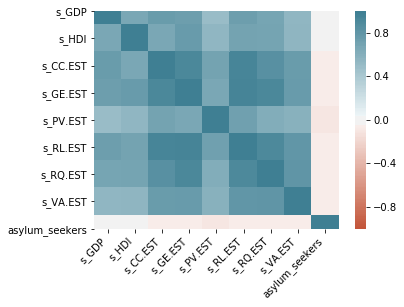

In [4]:
#seaborn heatmaps, more readable heatmaps below
corr = data[columns_source].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

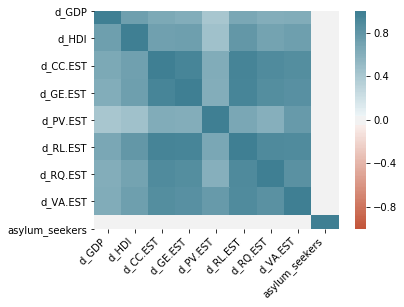

In [5]:
#seaborn heatmaps, more readable heatmaps below
corr = data[columns_dest].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [6]:
# https://github.com/drazenz/heatmap/blob/master/heatmap.py
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, n_colors, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=n_colors),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

### Correlation of asylum seekers with source country metrics  

As seen below, Human Development Index (HDI) and Gross Domestic Product (GDP) of an origin country don't show any correlation at all with the number of refugees fleeing from it. There are a few factors here that show at least some correlation though, namely the origin country's

- Political Stability and Absence of Violence (s_PV)
- Control of Corruption (s_CC) 
- Rule of Law (s_RL)  

as supplied by the World Governance Indicators from the World Bank. The other Indicators also have at least some influence as to the number of refugees in a given year, however the three Indicators above show the highest correlation amongst these.  

Size of the squares also represents correlation, in addition to color, like this: ` size(c1, c2) ~ abs(corr(c1, c2)) `

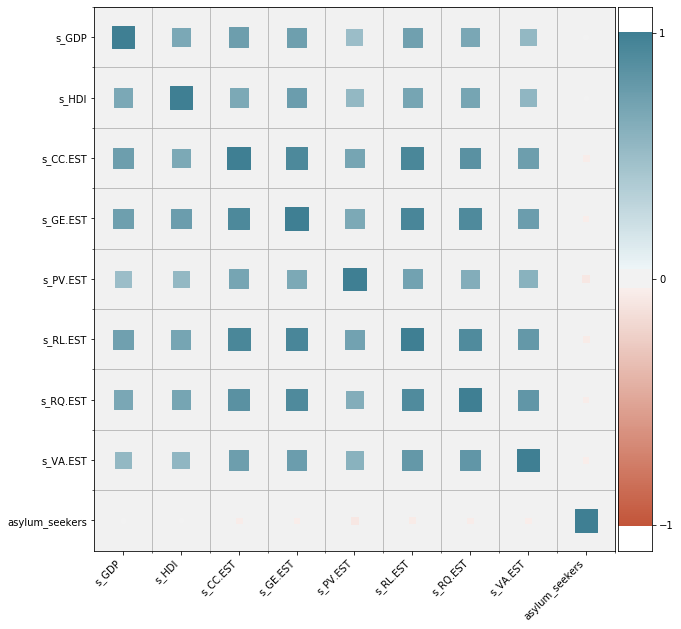

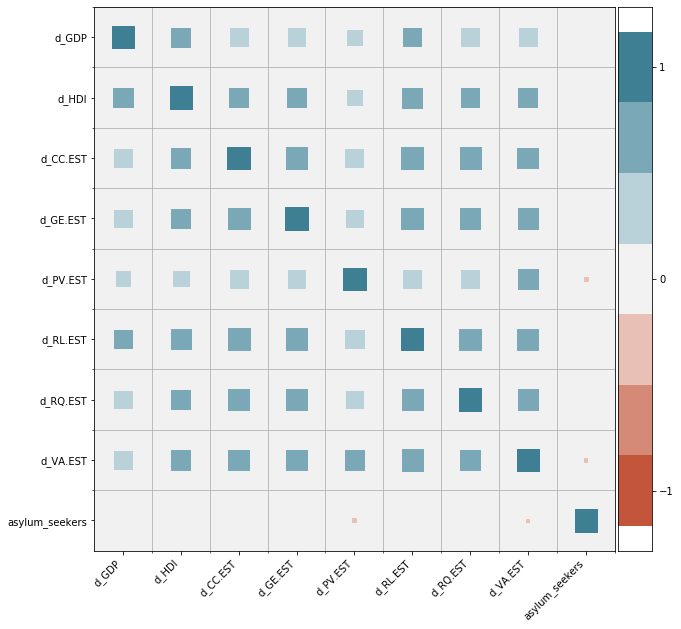

In [7]:
plt.figure(figsize=(10, 10))
corrplot(data[columns_source].corr(),256)

plt.figure(figsize=(10, 10))
corrplot(data[columns_dest].corr(),7)

### Correlation of asylum seekers with destination country metrics  

Here, there can be no correlation observed between the Indicators of a country's performance and the number of refugees fleeing to said country. The WGI show up in the heatmap at just a hair below zero (neg. correlation) only when the "steps" of the coloring are reduced from 256 colors to just 7. In this configuration, the Indicators mentioned in the section above are colored in the color that is just one step away from a correlation of zero.  

However, the sqaures displayed are still very small even in this configuration, suggesting that there is no significant correlation after all.

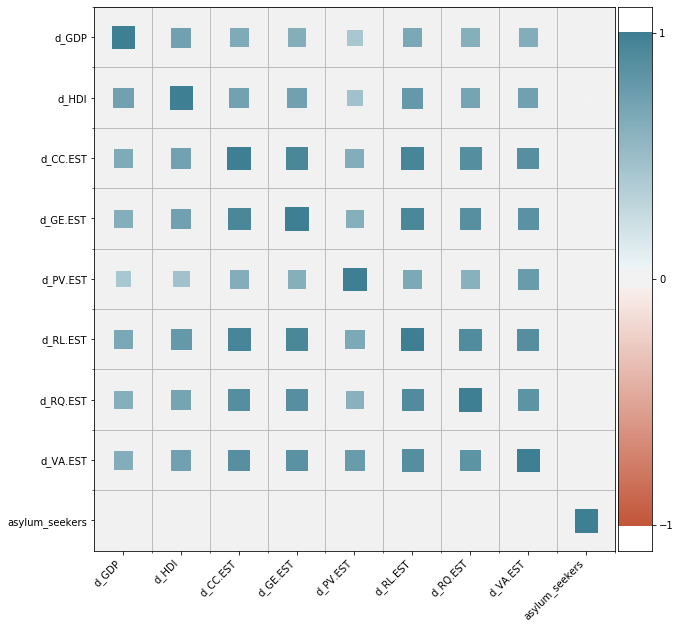

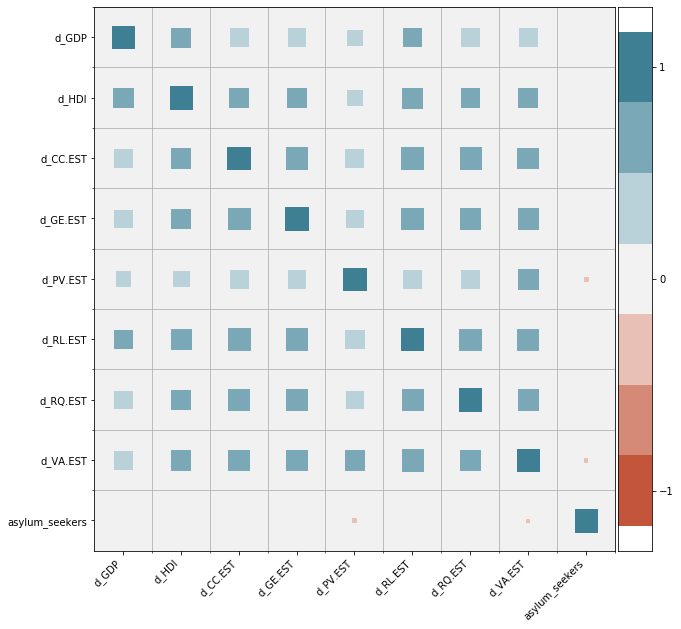

In [8]:
plt.figure(figsize=(10, 10))
corrplot(data[columns_dest].corr(),256)

plt.figure(figsize=(10, 10))
corrplot(data[columns_dest].corr(),7)

### Complete correlation heatmap

Here, we can again observe how turning down the number of possible colors can force some otherwise insignificant values to show up, that would not be visible with more possible colors.

However, at a lower "resolution" we can clearly observe how a source country's Indicators are far more significant to the number of refugees another country recieves than the Indicators of the country they are seeking asylum in.

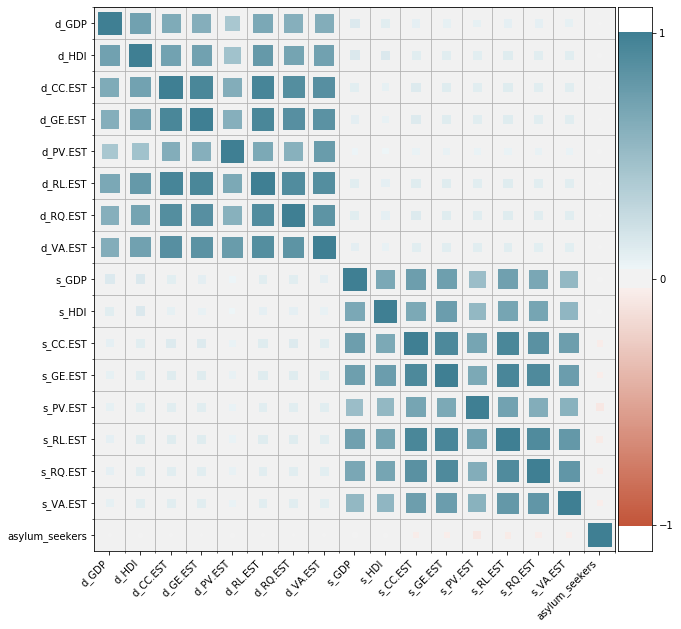

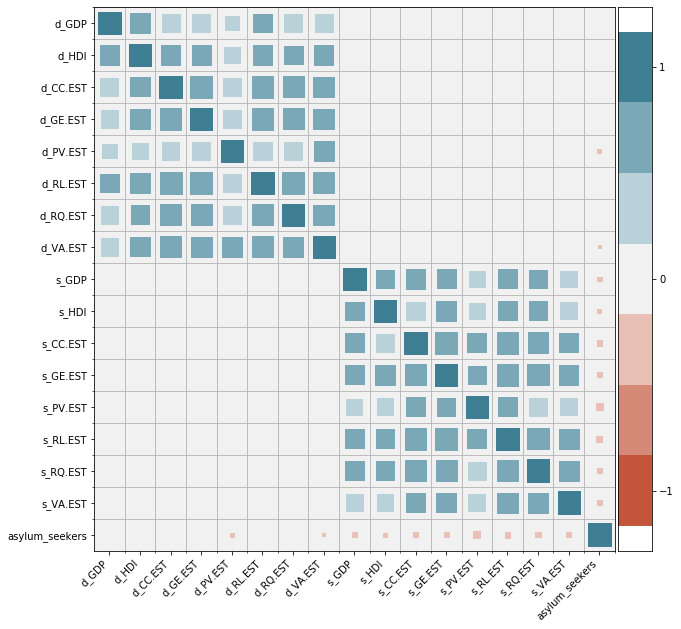

In [9]:
plt.figure(figsize=(10, 10))
corrplot(data.corr(),256)

plt.figure(figsize=(10, 10))
corrplot(data.corr(),7)

Thus, to answer the question from the beginning:

- Are there typical characteristics of refugee origin and destination countries?  

The World Governance Indicators of origin countries negatively correlate with the number of asylum seekers originating from there - when some Indicators decrease, the number of refugees originating from that country tends to increase. Important to notice, HDI and GDP have no correlation with the number of refugees fleeing a country or choosing a country to flee to.

### Country characteristics

The remaining question is as follows:

- Are there typical characteristics of large flows of refugees?

This question is similar to the one before it, and parts of this analysis here are relevant for the other question as well. Typically, large flows of refugees originate from countries with rather negative Indicators from the WGI, as well as lower HDI and GDP. Destination countries typically register a much higher GDP and HDI, as well as much better/higher Indicators from the WGI. 

Another (very important) aspect to notice is the historical and geographical background. Iran and Afghanistan have recorded some of the highest numbers of refugees fleeing these countries between 2000-2017, and Turkey has the highest influx of refugees in the world in this time period. These countries are, first and foremost, very close geographically, Iran brodering on Turkey and Afghanistan bordering on Iran. It stands to reason that refugees will flee to the nearest, safe country, even if its WGI and other metrics are not as good or as high as some other, far away countries. 

The same pattern is visible when looking at Serbia, producing about 500.000 refugees from 2000 onwards, and Hungary and neighboring states being among the countries with the highest refugee influx. Since we only use data here from 2000 onwards, only a small part of the Yugoslav War (1991-2001) is represented here. Still, it is enough to push Serbia to be the country producing the third-most refuguees in this time period.  

In [10]:
df = data.reset_index()
df.drop('year',axis=1,inplace=True)

#set format to prevent scientifc notation (e.g. 1.111e-08)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#compute mean of all metrics per origin/source country
df_origin = df.groupby('source').mean()
#drop destination metrics
df_origin.drop(['d_GDP', 'd_HDI', 'd_CC.EST', 'd_GE.EST', 'd_PV.EST', 'd_RL.EST','d_RQ.EST', 'd_VA.EST'],
               axis=1,inplace=True)
df_origin.rename(columns={'asylum_seekers':'asylum_seekers_produced_sum'},inplace=True)
#replace mean refugees by sum of all refugees produced
df_origin['asylum_seekers_produced_sum'] = df.groupby('source')['asylum_seekers'].sum()
#df_origin = df_origin.apply(lambda x: '%.5f' % x if x.name == 'asylum_seekers_produced_sum' else x, axis=1)
#sort by number of refugees
df_origin.reset_index(inplace=True)
df_origin.sort_values('asylum_seekers_produced_sum',ascending=False,inplace=True)


#compute mean of all metrics per destination country
df_dest = df.groupby('destination').mean()
#drop source metrics
df_dest.drop(['s_GDP', 's_HDI', 's_CC.EST', 's_GE.EST','s_PV.EST', 's_RL.EST', 's_RQ.EST', 's_VA.EST'],
               axis=1,inplace=True)
df_dest.rename(columns={'asylum_seekers':'asylum_seekers_sum'},inplace=True)
#replace mean refugees by sum of all refugees recieved
df_dest['asylum_seekers_sum'] = df.groupby('source')['asylum_seekers'].sum()
#sort by number of refugees
df_dest.reset_index(inplace=True)
df_dest.sort_values('asylum_seekers_sum',ascending=False,inplace=True)


display(df_origin.head(33))
display(df_dest)

#reset pandas display option
pd.reset_option('display.float_format')

,source,s_GDP,s_HDI,s_CC.EST,s_GE.EST,s_PV.EST,s_RL.EST,s_RQ.EST,s_VA.EST,asylum_seekers_produced_sum
161,Syria,1400.40549,0.60629,-1.13345,-1.07885,-1.26378,-0.96129,-1.28780,-1.75172,1058638.01040
0,Afghanistan,439.99645,0.44165,-1.45318,-1.39201,-2.44404,-1.69196,-1.49303,-1.24803,924854.31259
78,Iraq,4590.02118,0.64559,-1.35680,-1.41028,-2.30838,-1.58808,-1.35903,-1.26924,871230.76282
146,Serbia,5055.69663,0.75818,-0.41791,-0.17913,-0.38301,-0.49918,-0.23822,0.10631,517606.84198
35,China,4400.65216,0.68429,-0.43605,0.10478,-0.47740,-0.47327,-0.25674,-1.60329,383557.78544
137,Russia,8949.88269,0.77594,-0.95729,-0.36914,-0.97762,-0.85290,-0.34398,-0.84051,375794.58728
77,Iran,4806.11363,0.74424,-0.61310,-0.47198,-1.02821,-0.85116,-1.43291,-1.41866,347982.90506
126,Pakistan,973.51457,0.51465,-0.92488,-0.61937,-2.22600,-0.83695,-0.65790,-0.89728,341597.82172
122,Nigeria,1924.17722,0.49447,-1.15770,-1.02822,-1.89812,-1.14849,-0.87758,-0.64214,306990.74389
54,Eritrea,445.95248,0.42965,-0.54682,-1.30342,-0.74799,-1.20417,-1.94149,-2.07475,286521.46772


,destination,d_GDP,d_HDI,d_CC.EST,d_GE.EST,d_PV.EST,d_RL.EST,d_RQ.EST,d_VA.EST,asylum_seekers_sum
32,Turkey,9080.75903,0.73371,-0.06707,0.20175,-1.04689,0.02219,0.25859,-0.20267,216991.92134
21,Mexico,9018.07242,0.73982,-0.41828,0.18820,-0.56801,-0.47473,0.33923,0.13974,196712.14677
27,Slovak Republic,14542.94618,0.81776,0.25669,0.80977,0.91969,0.50704,0.97062,0.93680,21735.51872
12,Hungary,11976.43968,0.81565,0.44296,0.71943,0.82006,0.75729,1.00874,0.87135,20600.72086
5,Czech Republic,16607.19451,0.85265,0.38266,0.93870,0.94477,0.95285,1.11204,0.98441,13585.14027
25,Poland,10737.46196,0.82865,0.50028,0.58842,0.69921,0.62926,0.88290,0.98222,10849.94853
34,United States,48362.83819,0.90500,1.47007,1.57840,0.43354,1.59238,1.49090,1.17255,9889.36537
15,Israel,28674.71316,0.88294,0.93755,1.25818,-1.21114,0.96264,1.11999,0.67829,8776.99060
18,Korea,21461.25879,0.87171,0.49170,1.05888,0.33294,0.97446,0.89886,0.70156,5223.44788
19,Latvia,11290.01858,0.81112,0.28992,0.71446,0.55974,0.70812,1.00087,0.79692,2802.91578
